# Addressing Virginia's Digital Divide: Analyzing Broadband Gaps and Their Indicators **(Phases 1-3)**

## 1. LOADING DATA SET(s)

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from google.colab import drive
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from shapely import wkt
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

drive.mount('/content/drive')
shared_folder_path = '/content/drive/My Drive/ML4VA Project'

if os.path.exists(shared_folder_path):
    folder_path = shared_folder_path
else:
    raise FileNotFoundError("Folder not found in any known locations.")

VA_COUNTIES = os.path.join(folder_path, 'VA_Counties_Generalized.csv')
VA_UNSERVED_BROADBAND = os.path.join(folder_path, 'VA_locations_unserved_broadband.csv')
VA_HOTSPOTS = os.path.join(folder_path, 'VA_public_hotspots.csv')
VA_COUNTIES_INCOME = os.path.join(folder_path, 'va_counties_income.csv')
VA_CENSUS = os.path.join(folder_path, 'virginia_city_county_census_boundaries.geojson')

va_counties = pd.read_csv(VA_COUNTIES)
va_counties_income = pd.read_csv(VA_COUNTIES_INCOME)
va_unserved_broadband = pd.read_csv(VA_UNSERVED_BROADBAND)
va_hotspots = pd.read_csv(VA_HOTSPOTS)
counties_df = gpd.read_file(VA_CENSUS)

Mounted at /content/drive


## 2. VISUALIZING DATA

### Overview of VA Counties Dataset

In [ ]:
# FYI: dataset was last updated in 2022
#   - Maybe merge with a dataset containing average/median income per county

va_counties.info()
print(va_counties.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FID            134 non-null    int64  
 1   NAME           134 non-null    object 
 2   STATE_NAME     134 non-null    object 
 3   POP2010        134 non-null    int64  
 4   POP10_SQMI     134 non-null    float64
 5   POP2012        134 non-null    int64  
 6   POP12_SQMI     134 non-null    float64
 7   WHITE          134 non-null    int64  
 8   BLACK          134 non-null    int64  
 9   AMERI_ES       134 non-null    int64  
 10  ASIAN          134 non-null    int64  
 11  HAWN_PI        134 non-null    int64  
 12  HISPANIC       134 non-null    int64  
 13  OTHER          134 non-null    int64  
 14  MULT_RACE      134 non-null    int64  
 15  MALES          134 non-null    int64  
 16  FEMALES        134 non-null    int64  
 17  AGE_UNDER5     134 non-null    int64  
 18  AGE_5_9   

### Overview of VA Counties Income Dataset

In [ ]:
# This dataset was retrieved from here: https://hdpulse.nimhd.nih.gov/data-portal/social/table?socialtopic=030&socialtopic_options=social_6&demo=01001&demo_options=income_3&race=00&race_options=raceall_1&sex=0&sex_options=sexboth_1&age=001&age_options=ageall_1&statefips=51&statefips_options=area_states
#   - Downloaded the dataset for the three types of incomes, and merged them
#     in Excel
#   - Should merge this with the va_counties dataset

def clean_va_counties_income(df):
    income_cols = [
        'Median Family Income (Dollars)',
        'Median Household Income (Dollars)',
        'Vast Majority Income (Dollars)'
    ]

    for col in income_cols:
        df[col] = df[col].replace({',': '', '\$': ''}, regex=True)
        df[col] = pd.to_numeric(df[col])

    return df

pipeline = Pipeline([
    ('clean_income', FunctionTransformer(clean_va_counties_income))
])

va_counties_income_cleaned = pipeline.fit_transform(va_counties_income)

va_counties_income_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   County                             133 non-null    object
 1    FIPS                              133 non-null    int64 
 2   Median Family Income (Dollars)     133 non-null    int64 
 3   Median Household Income (Dollars)  133 non-null    int64 
 4   Vast Majority Income (Dollars)     133 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 5.3+ KB


In [ ]:
va_counties_income.head()

,County,FIPS,Median Family Income (Dollars),Median Household Income (Dollars),Vast Majority Income (Dollars)
0,Accomack County,51001,69408,52694,19020
1,Albemarle County,51003,126769,97708,31719
2,Alexandria City,51510,149526,113179,45167
3,Alleghany County and Clifton Forge City,51005,68965,52546,17835
4,Amelia County,51007,85575,63438,21417


### Merging VA Counties Income Dataset and VA Counties Dataset

In [ ]:
# Changing county names in va_counties_income and va_counties to be one to one
#    - Duplicating Bedford row to change one to county and one to city

bedford_row = va_counties_income[va_counties_income["County"] == "Bedford City and County"]
bedford_city = bedford_row.copy()
bedford_county = bedford_row.copy()
bedford_city["County"] = "Bedford City"
bedford_county["County"] = "Bedford County"

va_counties_income = pd.concat([va_counties_income, bedford_city, bedford_county], ignore_index=True)

va_counties_income = va_counties_income[va_counties_income["County"] != "Bedford City and County"]

# Dictionary of counties for which " County" or " City" should not be stripped
#    - Key is va_counties_income name, value is va_counties name
excp = {"Fairfax City": "Fairfax City",
        "Fairfax County": "Fairfax County",
        "Richmond City": "Richmond City",
        "Richmond County": "Richmond County",
        "Bedford City": "Bedford City",
        "Bedford County": "Bedford County",
        "Franklin City": "Franklin City",
        "Franklin County": "Franklin County",
        "Roanoke City": "Roanoke City",
        "Roanoke County": "Roanoke County",
        "Charles City County": "Charles City",
        "Halifax County with South Boston City": "Halifax",
        "James City County": "James City",
        "Alleghany County and Clifton Forge City": "Alleghany"
}

va_counties_income["County"] = va_counties_income["County"].apply(
    lambda x: excp[x] if x in excp.keys() else x.replace(" County", "").replace(" City", "")
)

merged_va_counties = pd.merge(va_counties_income, va_counties, left_on="County", right_on="NAME", how="inner")

In [ ]:
merged_va_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 58 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   County                             134 non-null    object 
 1    FIPS                              134 non-null    int64  
 2   Median Family Income (Dollars)     134 non-null    int64  
 3   Median Household Income (Dollars)  134 non-null    int64  
 4   Vast Majority Income (Dollars)     134 non-null    int64  
 5   FID                                134 non-null    int64  
 6   NAME                               134 non-null    object 
 7   STATE_NAME                         134 non-null    object 
 8   POP2010                            134 non-null    int64  
 9   POP10_SQMI                         134 non-null    float64
 10  POP2012                            134 non-null    int64  
 11  POP12_SQMI                         134 non-null    float64

In [ ]:
merged_va_counties.head()

,County,FIPS,Median Family Income (Dollars),Median Household Income (Dollars),Vast Majority Income (Dollars),FID,NAME,STATE_NAME,POP2010,POP10_SQMI,...,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS07,AVG_SIZE07,CROP_ACR07,AVG_SALE07,SQMI,Shape__Area,Shape__Length
0,Accomack,51001,69408,52694,19020,129,Accomack,Virginia,33164,73.1,...,7204,9963,3835,248,378,76576,617.10,453.63,1.725184e+09,320988.669843
1,Albemarle,51003,126769,97708,31719,116,Albemarle,Virginia,98970,136.3,...,3965,25061,13096,895,177,46216,27.01,726.10,3.008925e+09,259709.443305
2,Alexandria,51510,149526,113179,45167,98,Alexandria,Virginia,139966,9178.1,...,4294,29458,38624,-99,-99,-99,-99.00,15.25,7.376886e+07,36955.637995
3,Alleghany,51005,68965,52546,17835,6,Alleghany,Virginia,16250,36.2,...,1183,5349,1542,209,138,7970,10.09,448.79,1.868074e+09,241864.450670
4,Amelia,51007,85575,63438,21417,11,Amelia,Virginia,12690,35.4,...,538,3921,900,455,201,33503,151.09,358.50,1.509317e+09,196245.050788


In [ ]:
corr_matrix = merged_va_counties.corr(numeric_only = True)
corr_matrix["Vast Majority Income (Dollars)"].sort_values(ascending=False)

,Vast Majority Income (Dollars)
Vast Majority Income (Dollars),1.000000
Median Household Income (Dollars),0.946023
Median Family Income (Dollars),0.945836
AGE_25_34,0.441151
AGE_35_44,0.438710
POP12_SQMI,0.432337
MARHH_CHD,0.430869
WHITE,0.429821
POP10_SQMI,0.426333
AVE_FAM_SZ,0.422302


### Overview of VA Unserved Locations By Broadband Dataset

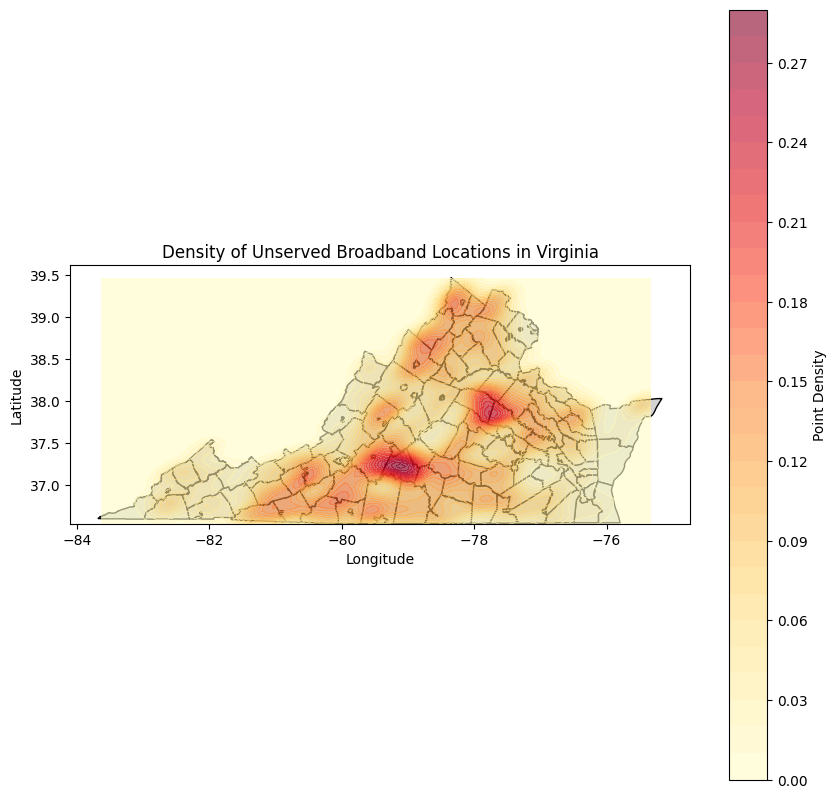

In [ ]:
# Overview of VA unserved locations by broadband dataset.
#   - Be wary that FCC is known to be overly optimizistic of broadband access
#   - May need to somehow weigh this feature less?

va_unserved_broadband[['longitude', 'latitude']] = (
    va_unserved_broadband['the_geom']
    .str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
    .astype(float)
)

fig, ax = plt.subplots(figsize=(10, 10))

counties_df.plot(ax=ax, color='lightgrey', edgecolor='black')

x = va_unserved_broadband['longitude']
y = va_unserved_broadband['latitude']

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

kde = gaussian_kde([x, y])
zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

contour = ax.contourf(xi, yi, zi, levels=30, cmap='YlOrRd', alpha=0.6)

cb = fig.colorbar(contour, ax=ax, label='Point Density')

ax.set_title("Density of Unserved Broadband Locations in Virginia")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

### Overview of VA Hotspots Dataset


In [ ]:
# Overview of VA hotspots data
#   - Step to add to pipeline further down. Dataset contains two rows where
#     longitude is incorrectly equal to 0

va_hotspots = va_hotspots[va_hotspots["Lon"] != 0]
va_hotspots.info()
print(va_hotspots.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 1080 entries, 0 to 1081
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              1080 non-null   int64  
 1   the_geom                         1080 non-null   object 
 2   Place                            1080 non-null   object 
 3   Address                          1080 non-null   object 
 4   City                             1080 non-null   object 
 5   Zip                              1080 non-null   int64  
 6   Locality                         1080 non-null   object 
 7   Wifi Password                    53 non-null     object 
 8   Lat                              1080 non-null   float64
 9   Lon                              1080 non-null   float64
 10  Virginia City/County Boundaries  0 non-null      float64
dtypes: float64(3), int64(2), object(6)
memory usage: 101.2+ KB
   _id                      

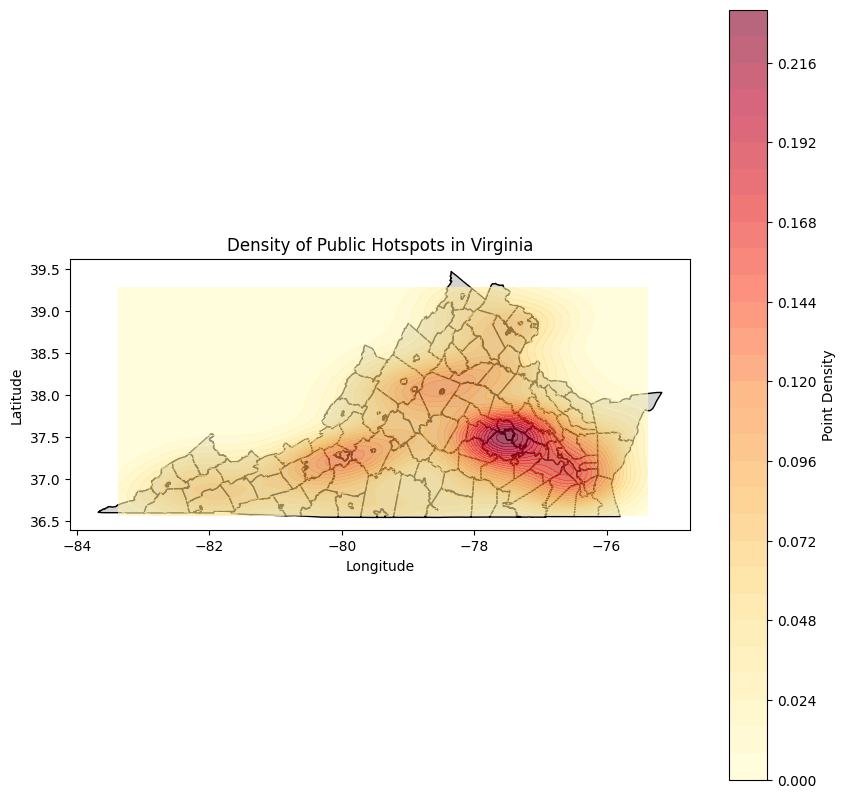

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

counties_df.plot(ax=ax, color='lightgrey', edgecolor='black')

x = va_hotspots['Lon']
y = va_hotspots['Lat']

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

kde = gaussian_kde([x, y])
zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

contour = ax.contourf(xi, yi, zi, levels=30, cmap='YlOrRd', alpha=0.6)

cb = fig.colorbar(contour, ax=ax, label='Point Density')

ax.set_title("Density of Public Hotspots in Virginia")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

## 3. DATA CLEANING

<!-- General steps we need to do:

- not sure how to handle the coordinate data...
  - count number of unserved broadband points and number of hotspots by county and use as features?
  - calculate distance from unserved broadband location to nearest hotspot and use as feature? -->

In [ ]:
merged_va_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 58 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   County                             134 non-null    object 
 1    FIPS                              134 non-null    int64  
 2   Median Family Income (Dollars)     134 non-null    int64  
 3   Median Household Income (Dollars)  134 non-null    int64  
 4   Vast Majority Income (Dollars)     134 non-null    int64  
 5   FID                                134 non-null    int64  
 6   NAME                               134 non-null    object 
 7   STATE_NAME                         134 non-null    object 
 8   POP2010                            134 non-null    int64  
 9   POP10_SQMI                         134 non-null    float64
 10  POP2012                            134 non-null    int64  
 11  POP12_SQMI                         134 non-null    float64

In [ ]:
va_hotspots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1080 entries, 0 to 1081
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              1080 non-null   int64  
 1   the_geom                         1080 non-null   object 
 2   Place                            1080 non-null   object 
 3   Address                          1080 non-null   object 
 4   City                             1080 non-null   object 
 5   Zip                              1080 non-null   int64  
 6   Locality                         1080 non-null   object 
 7   Wifi Password                    53 non-null     object 
 8   Lat                              1080 non-null   float64
 9   Lon                              1080 non-null   float64
 10  Virginia City/County Boundaries  0 non-null      float64
dtypes: float64(3), int64(2), object(6)
memory usage: 101.2+ KB


In [ ]:
va_unserved_broadband.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349733 entries, 0 to 349732
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   the_geom   349733 non-null  object 
 1   addptkey   349733 non-null  int64  
 2   longitude  349733 non-null  float64
 3   latitude   349733 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 10.7+ MB


In [ ]:
va_unserved_broadband.head()

,the_geom,addptkey,longitude,latitude
0,POINT (-79.47808178699995 36.54064660999978),196360013,-79.478082,36.540647
1,POINT (-80.97733184599997 37.1943242459998),-131150133606,-80.977332,37.194324
2,POINT (-79.36593935899998 37.397714484999796),11869155138,-79.365939,37.397714
3,POINT (-80.90230071799994 36.56653752699975),-12554563838,-80.902301,36.566538
4,POINT (-78.05235319499997 37.71101736899979),127618190895,-78.052353,37.711017


In [ ]:
va_hotspots.head()

,_id,the_geom,Place,Address,City,Zip,Locality,Wifi Password,Lat,Lon,Virginia City/County Boundaries
0,1,POINT (-77.43050306899994 37.30053547600005),Carver Middle,3800 Cougar Trail,Chester,23831,Chesterfield County,NaN,37.301626,-77.431094,NaN
1,2,POINT (-79.67927540599999 37.52832304100008),Buchanan Library,19795 Main Street,Buchanan,24066,Botetourt County,NaN,37.528455,-79.679400,NaN
2,3,POINT (-82.33777122999999 37.06172284000007),Roos Grill,2744 Dante Mountain Road,Nora,24272,Dickenson County,NaN,37.021892,-82.347655,NaN
3,4,POINT (-76.29397433099996 36.84614663800005),TOWN POINT PARK,113 WATERSIDE DRIVE,Norfolk,23510,Norfolk City,NaN,36.845918,-76.294568,NaN
4,5,POINT (-77.34369094399995 37.61368245700004),Mechanicsville Branch Library,7461 Sherwood Crossing Place,Mechanicsville,23111,Hanover County,NaN,37.613671,-77.344218,NaN


In [ ]:
va_unserved_broadband.head()

,the_geom,addptkey,longitude,latitude
0,POINT (-79.47808178699995 36.54064660999978),196360013,-79.478082,36.540647
1,POINT (-80.97733184599997 37.1943242459998),-131150133606,-80.977332,37.194324
2,POINT (-79.36593935899998 37.397714484999796),11869155138,-79.365939,37.397714
3,POINT (-80.90230071799994 36.56653752699975),-12554563838,-80.902301,36.566538
4,POINT (-78.05235319499997 37.71101736899979),127618190895,-78.052353,37.711017


In [ ]:
va_hotspots['geometry'] = va_hotspots.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)

hotspots_gdf = gpd.GeoDataFrame(va_hotspots, geometry='geometry', crs="EPSG:4326")

if counties_df.crs != hotspots_gdf.crs:
    hotspots_gdf = hotspots_gdf.to_crs(counties_df.crs)

hotspots_in_counties = gpd.sjoin(hotspots_gdf, counties_df, how="inner", predicate="within")

hotspot_counts = hotspots_in_counties.groupby('NAMELSAD').size()
hotspot_counts = hotspot_counts.rename("hotspot_count").reset_index()

counties_with_hotspots = counties_df.merge(hotspot_counts, on='NAMELSAD', how='left')
counties_with_hotspots['hotspot_count'] = counties_with_hotspots['hotspot_count'].fillna(0)  # Fill NaN with 0

print(counties_with_hotspots[['NAMELSAD', 'hotspot_count']])

               NAMELSAD  hotspot_count
0            Galax city            0.0
1         Richmond city            9.0
2         Hopewell city            1.0
3    Northampton County            9.0
4         Warren County            3.0
..                  ...            ...
129        Wythe County            3.0
130     Buchanan County            4.0
131        Giles County            7.0
132  Mecklenburg County           15.0
133      Grayson County            6.0

[134 rows x 2 columns]


In [ ]:
counties_with_hotspots_sorted = counties_with_hotspots.sort_values(by='hotspot_count', ascending=False)
print(counties_with_hotspots_sorted[['NAMELSAD', 'hotspot_count']])

                NAMELSAD  hotspot_count
85   Chesterfield County           74.0
42        Henrico County           66.0
50     Newport News city           49.0
62        Roanoke County           33.0
121     Albemarle County           29.0
..                   ...            ...
18       Waynesboro city            0.0
64       Portsmouth city            0.0
109      Petersburg city            0.0
58    Manassas Park city            0.0
0             Galax city            0.0

[134 rows x 2 columns]


In [ ]:
va_unserved_broadband['geometry'] = va_unserved_broadband['the_geom'].apply(wkt.loads)

unserved_gdf = gpd.GeoDataFrame(va_unserved_broadband, geometry='geometry', crs="EPSG:4326")

if counties_df.crs != unserved_gdf.crs:
    unserved_gdf = unserved_gdf.to_crs(counties_df.crs)

unserved_in_counties = gpd.sjoin(unserved_gdf, counties_df, how="inner", predicate="within")

unserved_counts = unserved_in_counties.groupby('NAMELSAD').size()
unserved_counts = unserved_counts.rename("unserved_count").reset_index()

counties_with_unserved = counties_df.merge(unserved_counts, on='NAMELSAD', how='left')
counties_with_unserved['unserved_count'] = counties_with_unserved['unserved_count'].fillna(0)  # Fill NaN with 0

print(counties_with_unserved[['NAMELSAD', 'unserved_count']])

               NAMELSAD  unserved_count
0            Galax city           199.0
1         Richmond city           390.0
2         Hopewell city             5.0
3    Northampton County           345.0
4         Warren County          2112.0
..                  ...             ...
129        Wythe County          5119.0
130     Buchanan County          2040.0
131        Giles County          2650.0
132  Mecklenburg County          6582.0
133      Grayson County          6733.0

[134 rows x 2 columns]


In [ ]:
counties_with_unserved_sorted = counties_with_unserved.sort_values(by='unserved_count', ascending=False)
print(counties_with_unserved_sorted[['NAMELSAD', 'unserved_count']])

                 NAMELSAD  unserved_count
65        Campbell County         15960.0
7          Bedford County         12064.0
94          Louisa County         10776.0
104       Franklin County         10726.0
89    Pittsylvania County          9441.0
..                    ...             ...
116        Covington city             2.0
99      Falls Church city             0.0
63           Bristol city             0.0
11   Charlottesville city             0.0
111         Franklin city             0.0

[134 rows x 2 columns]


In [ ]:
# renaming counties in counties_with_unserved_sorted to match merged_va_counties
# key counties_with_unserved_sorted name : value merged_va_counties name
excp = {
    "Fairfax County": "Fairfax County",
    "Fairfax city": "Fairfax City",
    "Richmond County": "Richmond County",
    "Richmond city": "Richmond City",
    "Roanoke County": "Roanoke County",
    "Roanoke city": "Roanoke City",
    "Franklin County": "Franklin County",
    "Franklin city": "Franklin City",
    "Bedford city": "Bedford City",
    "Bedford County": "Bedford County",
    "Bedford": "Bedford County"
}

counties_with_unserved_sorted['NAMELSAD'] = counties_with_unserved_sorted['NAMELSAD'].apply(
    lambda x: excp[x] if x in excp.keys() else x.replace(" County", "").replace(" city", "")
)

merged_va_counties = merged_va_counties.merge(
    counties_with_unserved_sorted[['NAMELSAD', 'unserved_count']],
    how='left',
    left_on='County',
    right_on='NAMELSAD'
)

merged_va_counties = merged_va_counties.drop(columns=['NAMELSAD'])

counties_with_hotspots_sorted['NAMELSAD'] = counties_with_hotspots_sorted['NAMELSAD'].apply(
    lambda x: excp[x] if x in excp.keys() else x.replace(" County", "").replace(" city", "")
)

merged_va_counties = merged_va_counties.merge(
    counties_with_hotspots_sorted[['NAMELSAD', 'hotspot_count']],
    how='left',
    left_on='County',
    right_on='NAMELSAD'
)

merged_va_counties = merged_va_counties.drop(columns=['NAMELSAD'])

In [ ]:
merged_va_counties

,County,FIPS,Median Family Income (Dollars),Median Household Income (Dollars),Vast Majority Income (Dollars),FID,NAME,STATE_NAME,POP2010,POP10_SQMI,...,RENTER_OCC,NO_FARMS07,AVG_SIZE07,CROP_ACR07,AVG_SALE07,SQMI,Shape__Area,Shape__Length,unserved_count,hotspot_count
0,Accomack,51001,69408,52694,19020,129,Accomack,Virginia,33164,73.1,...,3835,248,378,76576,617.10,453.63,1.725184e+09,320988.669843,3059.0,9.0
1,Albemarle,51003,126769,97708,31719,116,Albemarle,Virginia,98970,136.3,...,13096,895,177,46216,27.01,726.10,3.008925e+09,259709.443305,5251.0,29.0
2,Alexandria,51510,149526,113179,45167,98,Alexandria,Virginia,139966,9178.1,...,38624,-99,-99,-99,-99.00,15.25,7.376886e+07,36955.637995,87.0,4.0
3,Alleghany,51005,68965,52546,17835,6,Alleghany,Virginia,16250,36.2,...,1542,209,138,7970,10.09,448.79,1.868074e+09,241864.450670,796.0,4.0
4,Amelia,51007,85575,63438,21417,11,Amelia,Virginia,12690,35.4,...,900,455,201,33503,151.09,358.50,1.509317e+09,196245.050788,1419.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,Wise,51195,57953,47541,14861,72,Wise,Virginia,41452,102.3,...,4546,178,125,3835,6.68,405.16,1.642953e+09,222316.245372,2065.0,18.0
130,Wythe,51197,72828,53921,18647,45,Wythe,Virginia,29235,62.9,...,3267,946,168,51991,40.35,464.60,1.916250e+09,188214.361356,5119.0,3.0
131,York,51199,123510,105154,32300,32,York,Virginia,65464,605.3,...,5962,45,29,292,88.37,108.15,4.402748e+08,121920.040950,603.0,3.0
132,Bedford City,51917,87064,74773,24935,39,Bedford City,Virginia,6222,901.7,...,1164,-99,-99,-99,-99.00,6.90,2.291740e+07,18966.895937,106.0,5.0


In [ ]:
numeric_df = merged_va_counties.select_dtypes(include='object')
numeric_columns = merged_va_counties.select_dtypes(include='object').columns
va_counties_prepared = merged_va_counties.copy()
va_counties_prepared.drop(numeric_columns, axis=1, inplace=True)
features_to_drop = {" FIPS", "FID"}
va_counties_prepared.drop(features_to_drop, axis=1, inplace=True)
va_counties_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Median Family Income (Dollars)     134 non-null    int64  
 1   Median Household Income (Dollars)  134 non-null    int64  
 2   Vast Majority Income (Dollars)     134 non-null    int64  
 3   POP2010                            134 non-null    int64  
 4   POP10_SQMI                         134 non-null    float64
 5   POP2012                            134 non-null    int64  
 6   POP12_SQMI                         134 non-null    float64
 7   WHITE                              134 non-null    int64  
 8   BLACK                              134 non-null    int64  
 9   AMERI_ES                           134 non-null    int64  
 10  ASIAN                              134 non-null    int64  
 11  HAWN_PI                            134 non-null    int64  

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

features_to_combine = [
    "WHITE", "BLACK", "AMERI_ES", "ASIAN", "HAWN_PI", "HISPANIC",
    "OTHER", "MULT_RACE", "MALES", "FEMALES", "AGE_UNDER5", "AGE_5_9", "AGE_10_14", "AGE_15_19", "AGE_20_24",
    "AGE_25_34", "AGE_35_44", "AGE_45_54", "AGE_55_64", "AGE_65_74", "AGE_75_84", "AGE_85_UP",
    "HOUSEHOLDS", "HSEHLD_1_M", "HSEHLD_1_F", "MARHH_CHD", "MARHH_NO_C", "MHH_CHILD",
    "FHH_CHILD", "FAMILIES", "HSE_UNITS", "VACANT", "OWNER_OCC", "RENTER_OCC", "NO_FARMS07",
    "CROP_ACR07", "SQMI", "Shape__Area", "unserved_count", "hotspot_count"
]

class PerPopulationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, population_column="POP2012", features_to_transform=None):
        self.population_column = population_column
        self.features_to_transform = features_to_transform
        self.new_columns = None

    def fit(self, X, y=None):
        self.new_columns = [
            f"{feature}_per_population" for feature in self.features_to_transform
        ]
        return self

    def transform(self, X):
        X = X.copy()
        X[self.population_column] = X[self.population_column].replace(0, 1e-7)

        for feature in self.features_to_transform:
            new_column_name = f"{feature}_per_population"
            X[new_column_name] = X[feature] / X[self.population_column]
            X = X.drop(columns=[feature])
        return X


num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

full_pipeline = Pipeline([
    ("per_population", PerPopulationTransformer(population_column="POP2012", features_to_transform=features_to_combine)),
    ("std_scaler", StandardScaler())
])


prepared_data = full_pipeline.fit_transform(va_counties_prepared)


per_population_transformer = full_pipeline.named_steps["per_population"]
new_feature_names = per_population_transformer.new_columns
remaining_columns = [col for col in va_counties_prepared.columns if col not in features_to_combine]
final_feature_names = new_feature_names + remaining_columns


va_counties_prepared = pd.DataFrame(prepared_data, columns=final_feature_names)
print(va_counties_prepared.head(5))

   WHITE_per_population  BLACK_per_population  AMERI_ES_per_population  \
0             -0.694516             -0.745582                -0.546864   
1              1.299049              0.993921                 1.174328   
2              2.089961              1.591777                 2.997037   
3             -0.709912             -0.751302                -0.707476   
4             -0.132636             -0.330395                -0.221980   

   ASIAN_per_population  HAWN_PI_per_population  HISPANIC_per_population  \
0             -0.228520               -0.502211                -0.233937   
1              0.337987               -0.460220                 0.339268   
2              0.690911                5.547262                 0.697744   
3             -0.374129               -0.526728                -0.375023   
4             -0.404776               -0.527260                -0.403664   

   OTHER_per_population  MULT_RACE_per_population  MALES_per_population  \
0             -0.499505

In [ ]:
# prepared_data = full_pipeline.fit_transform(va_counties_prepared)

# per_population_transformer = full_pipeline.named_steps["per_population"]
# new_feature_names = per_population_transformer.new_columns
# final_feature_names = new_feature_names  # These are the transformed feature names

# va_counties_prepared = pd.DataFrame(prepared_data, columns=final_feature_names)

# print(va_counties_prepared.head())

## 4. MODEL SELECTION

In [ ]:
# kmeans = KMeans(n_clusters=4, random_state=42)
# y_pred = kmeans.fit_predict(va_counties_actual_prepared)

# county_names = merged_va_counties[['County']]
# test_df = pd.DataFrame(va_counties_actual_prepared)
# test_df['cluster'] = y_pred
# test_df = test_df.join(county_names)

In [ ]:
# clusters_with_counties = test_df.groupby('cluster')['County'].apply(list).reset_index()

# clusters_with_counties

In [ ]:
# sse = []
# k_rng = range(1,10)
# for k in k_rng:
#     km = KMeans(n_clusters=k)
#     km.fit(va_counties_actual_prepared)
#     sse.append(km.inertia_)
#     print(k, km.inertia_)

# plt.xlabel('K')
# plt.ylabel('Sum of Squared Error')
# plt.plot(k_rng,sse)

In [ ]:
# name_mapping = {
#     "Fairfax County": "Fairfax County",
#     "Fairfax city": "Fairfax City",
#     "Richmond County": "Richmond County",
#     "Richmond city": "Richmond City",
#     "Roanoke County": "Roanoke County",
#     "Roanoke city": "Roanoke City",
#     "Franklin County": "Franklin County",
#     "Franklin city": "Franklin City",
#     "Bedford city": "Bedford City",
#     "Bedford County": "Bedford County",
#     "Bedford": "Bedford County"
# }

# counties_df['NAMELSAD'] = counties_df['NAMELSAD'].apply(
#     lambda x: name_mapping[x] if x in name_mapping else x.replace(" County", "").replace(" city", "")
# )

# counties_with_clusters = counties_df.merge(test_df[['County', 'cluster']], left_on='NAMELSAD', right_on='County', how='left')

# counties_with_clusters['cluster'] = counties_with_clusters['cluster'].fillna(-1).astype(int)

# unique_clusters = counties_with_clusters['cluster'].unique()

# cmap = mcolors.ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA', '#FFAAFF'])  # 4 different colors

# fig, ax = plt.subplots(figsize=(10, 10))

# counties_with_clusters.plot(column='cluster', ax=ax, legend=True, cmap=cmap,
#                             legend_kwds={'label': "Cluster by County", 'orientation': "horizontal"})

# ax.set_title('Virginia Counties and Cities Clusters', fontsize=16)
# ax.set_xlabel('Longitude', fontsize=12)
# ax.set_ylabel('Latitude', fontsize=12)

# handles, labels = ax.get_legend_handles_labels()
# labels = ['Cluster ' + str(i) for i in range(4)]
# ax.legend(handles, labels, title="Clusters", loc="upper left")

# plt.show()

## 5. MODEL TUNING

# Addressing Virginia's Digital Divide: Analyzing Broadband Gaps and Their Indicators **(Phases 4-5)**

In [ ]:
def plot_kmeans_sse(data, k_range=(1, 10)):
    sse = []
    k_values = range(k_range[0], k_range[1] + 1)

    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(data)
        sse.append(km.inertia_)
        print(f"k={k}, SSE={km.inertia_}")

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, sse, marker='o')
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Sum of Squared Error (SSE)', fontsize=12)
    plt.title('Elbow Method for Optimal k', fontsize=14)
    plt.grid(True)
    plt.show()

def plot_clusters_on_map(counties_df, test_df, name_mapping, cluster_column='cluster'):
  counties_df['NAMELSAD'] = counties_df['NAMELSAD'].apply(
      lambda x: name_mapping.get(x, x.replace(" County", "").replace(" city", ""))
  )

  counties_with_clusters = counties_df.merge(
      test_df[['County', cluster_column]],
      left_on='NAMELSAD',
      right_on='County',
      how='left'
  )

  counties_with_clusters[cluster_column] = counties_with_clusters[cluster_column].fillna(-1).astype(int)

  num_clusters = counties_with_clusters[cluster_column].nunique()

  cmap = plt.cm.get_cmap('tab10', num_clusters)

  fig, ax = plt.subplots(figsize=(12, 12))
  counties_with_clusters.plot(
      column=cluster_column,
      ax=ax,
      cmap=cmap,
      legend=True,
      legend_kwds={'label': "Cluster by County", 'orientation': "horizontal"}
  )

  ax.set_title('Virginia Counties and Cities Clusters', fontsize=16)
  ax.set_xlabel('Longitude', fontsize=12)
  ax.set_ylabel('Latitude', fontsize=12)

  handles, labels = ax.get_legend_handles_labels()
  ax.legend(
      handles=handles,
      labels=[f"Cluster {int(label)}" if int(label) != -1 else "Unassigned" for label in labels],
      title="Clusters",
      loc="upper left"
  )

  plt.show()

name_mapping = {
  "Fairfax County": "Fairfax County",
  "Fairfax city": "Fairfax City",
  "Richmond County": "Richmond County",
  "Richmond city": "Richmond City",
  "Roanoke County": "Roanoke County",
  "Roanoke city": "Roanoke City",
  "Franklin County": "Franklin County",
  "Franklin city": "Franklin City",
  "Bedford city": "Bedford City",
  "Bedford County": "Bedford County",
  "Bedford": "Bedford County"
}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WHITE_per_population               134 non-null    float64
 1   BLACK_per_population               134 non-null    float64
 2   AMERI_ES_per_population            134 non-null    float64
 3   ASIAN_per_population               134 non-null    float64
 4   HAWN_PI_per_population             134 non-null    float64
 5   HISPANIC_per_population            134 non-null    float64
 6   OTHER_per_population               134 non-null    float64
 7   MULT_RACE_per_population           134 non-null    float64
 8   MALES_per_population               134 non-null    float64
 9   FEMALES_per_population             134 non-null    float64
 10  AGE_UNDER5_per_population          134 non-null    float64
 11  AGE_5_9_per_population             134 non-null    float64

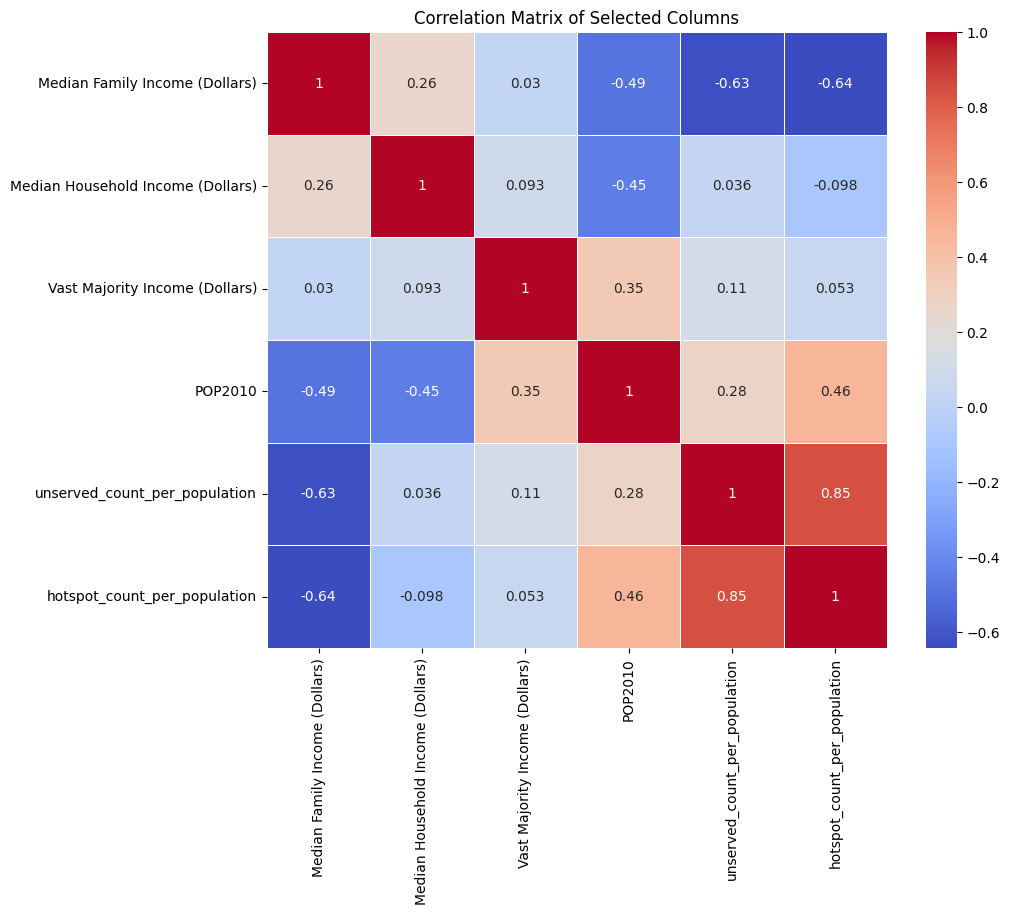

In [ ]:
# plotting correlation matrix

print(va_counties_prepared.info())

columns_of_interest = [
    'Median Family Income (Dollars)',
    'Median Household Income (Dollars)',
    'Vast Majority Income (Dollars)',
    'POP2010',
    'unserved_count_per_population',
    'hotspot_count_per_population'
]

filtered_df = va_counties_prepared[columns_of_interest]

correlation_matrix = filtered_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Columns')
plt.show()

### Random Forest for Feature Importance


In [ ]:
target_column = 'engineered_target'
va_counties_prepared['engineered_target'] = va_counties_prepared['hotspot_count_per_population'] * (va_counties_prepared['unserved_count_per_population'] + 1e-7)

X = va_counties_prepared.drop(columns=['engineered_target'])
y = va_counties_prepared['engineered_target']

# smaller test size because of small dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 12],
    'max_leaf_nodes': [4, 6, 9, 11, 13],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=7,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)
cv_results = pd.DataFrame(grid_search.cv_results_)
print("\nMetrics for Each Combination:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nBest Parameters:", grid_search.best_params_)
print("Best Model MSE:", mse)
print("Best Model R^2:", r2)

final_importances = best_model.feature_importances_
final_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_importances
}).sort_values(by='Importance', ascending=False)

# select top 30 features
top_features = final_features.head(30)['Feature'].tolist()

# ensure Vast Majority Income is included in the selected features
# if "Vast Majority Income (Dollars)" not in top_features:
#     top_features.append("Vast Majority Income (Dollars)")

va_counties_selected = va_counties_prepared[top_features]

print("\nTop Features by Best Model:")
print(final_features.head(30))

Fitting 7 folds for each of 120 candidates, totalling 840 fits

Metrics for Each Combination:
                                                params  mean_test_score  \
0    {'max_depth': 4, 'max_features': 'sqrt', 'max_...        -0.728680   
1    {'max_depth': 4, 'max_features': 'sqrt', 'max_...        -0.804047   
2    {'max_depth': 4, 'max_features': 'sqrt', 'max_...        -0.849172   
3    {'max_depth': 4, 'max_features': 'sqrt', 'max_...        -0.616094   
4    {'max_depth': 4, 'max_features': 'sqrt', 'max_...        -0.662650   
..                                                 ...              ...   
115  {'max_depth': 12, 'max_features': 'log2', 'max...        -0.678069   
116  {'max_depth': 12, 'max_features': 'log2', 'max...        -0.711055   
117  {'max_depth': 12, 'max_features': 'log2', 'max...        -0.621633   
118  {'max_depth': 12, 'max_features': 'log2', 'max...        -0.662508   
119  {'max_depth': 12, 'max_features': 'log2', 'max...        -0.698344   

     

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Clustering Method 1 - K means


In [ ]:
# num_pipeline = Pipeline([
#   ('std_scaler', StandardScaler()),
# ])

# full_pipeline = ColumnTransformer([
#   ("num", num_pipeline, list(va_counties_selected)),
# ])

va_counties_selected_prepared = va_counties_selected

kmeans = KMeans(n_clusters=6, random_state=42)
y_pred = kmeans.fit_predict(va_counties_selected_prepared)

county_names = merged_va_counties[['County']]
test_df = pd.DataFrame(va_counties_selected_prepared)
test_df['cluster'] = y_pred
test_df = test_df.join(county_names)

clusters_with_counties = test_df.groupby('cluster')['County'].apply(list).reset_index()

sil_score = silhouette_score(va_counties_selected_prepared, y_pred)

print("Silhouette Score:", sil_score)

clusters_with_counties

Silhouette Score: 0.21775885049311017


,cluster,County
0,0,"[Accomack, Bath, Grayson, Highland, Lancaster,..."
1,1,"[Albemarle, Caroline, Chesapeake, Chesterfield..."
2,2,"[Bristol, Buena Vista, Colonial Heights, Covin..."
3,3,"[Fairfax City, Fairfax County, Falls Church, L..."
4,4,"[Alleghany, Amelia, Amherst, Appomattox, Augus..."
5,5,"[Alexandria, Arlington, Charlottesville, Frede..."


In [ ]:
def find_cluster_min_unserved(df):
    cluster_broadband_sum = df.groupby('cluster')['unserved_count_per_population'].sum().reset_index()
    min_broadband_cluster = cluster_broadband_sum.loc[cluster_broadband_sum['unserved_count_per_population'].idxmin()]
    min_cluster_number = min_broadband_cluster['cluster']
    counties_in_min_cluster = df[df['cluster'] == min_cluster_number]['County'].unique()

    print(f"Cluster with lowest total unserved_count_per_population: {min_cluster_number}")
    print("Counties in cluster:", counties_in_min_cluster)

def find_cluster_min_hotspot(df):
    cluster_broadband_sum = df.groupby('cluster')['hotspot_count_per_population'].sum().reset_index()
    min_broadband_cluster = cluster_broadband_sum.loc[cluster_broadband_sum['hotspot_count_per_population'].idxmin()]
    min_cluster_number = min_broadband_cluster['cluster']
    counties_in_min_cluster = df[df['cluster'] == min_cluster_number]['County'].unique()

    print(f"Cluster with lowest total hotspot_count_per_population: {min_cluster_number}")
    print("Counties in cluster:", counties_in_min_cluster)

In [ ]:
find_cluster_min_unserved(test_df)
print()
find_cluster_min_hotspot(test_df)

Cluster with lowest total unserved_count_per_population: 1.0
Counties in cluster: ['Albemarle' 'Caroline' 'Chesapeake' 'Chesterfield' 'Culpeper' 'Fauquier'
 'Fluvanna' 'Frederick' 'Gloucester' 'Goochland' 'Greene' 'Hanover'
 'Henrico' 'Isle of Wight' 'James City' 'King George' 'King William'
 'New Kent' 'Orange' 'Poquoson' 'Powhatan' 'Prince George' 'Spotsylvania'
 'Stafford' 'Suffolk' 'Virginia Beach' 'Warren' 'York']

Cluster with lowest total hotspot_count_per_population: 1.0
Counties in cluster: ['Albemarle' 'Caroline' 'Chesapeake' 'Chesterfield' 'Culpeper' 'Fauquier'
 'Fluvanna' 'Frederick' 'Gloucester' 'Goochland' 'Greene' 'Hanover'
 'Henrico' 'Isle of Wight' 'James City' 'King George' 'King William'
 'New Kent' 'Orange' 'Poquoson' 'Powhatan' 'Prince George' 'Spotsylvania'
 'Stafford' 'Suffolk' 'Virginia Beach' 'Warren' 'York']


k=1, SSE=4020.000000000001
k=2, SSE=3128.032112627257
k=3, SSE=2507.374200520799
k=4, SSE=2199.1811987034393
k=5, SSE=2028.6723645763163
k=6, SSE=1814.486480470207
k=7, SSE=1745.2630233188918
k=8, SSE=1603.2542959374284
k=9, SSE=1356.9502974167815
k=10, SSE=1251.673752509518


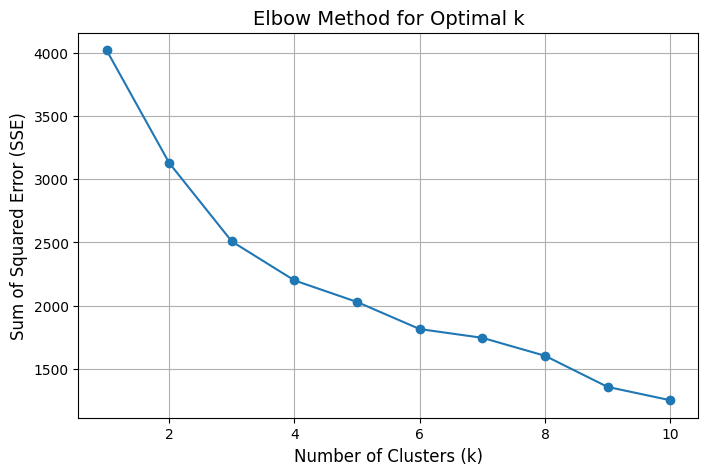

In [ ]:
plot_kmeans_sse(va_counties_selected_prepared, k_range=(1, 10))

<ipython-input-32-d6afe6ad3e7a>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_clusters)


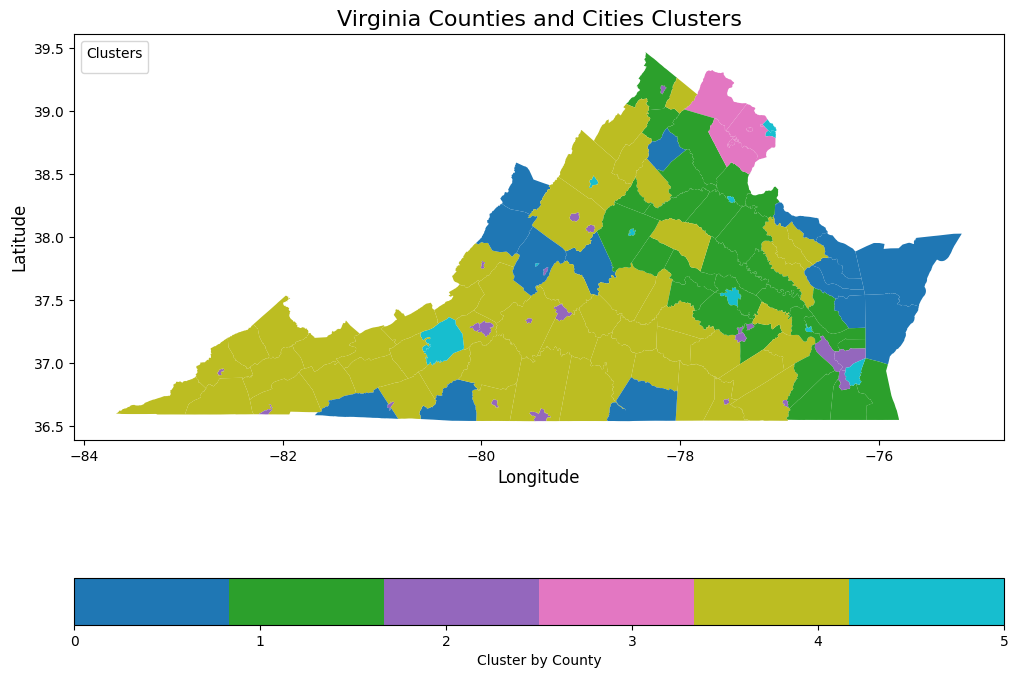

In [ ]:
plot_clusters_on_map(counties_df, test_df, name_mapping, cluster_column='cluster')

### Clustering Method 2 - Dendogram

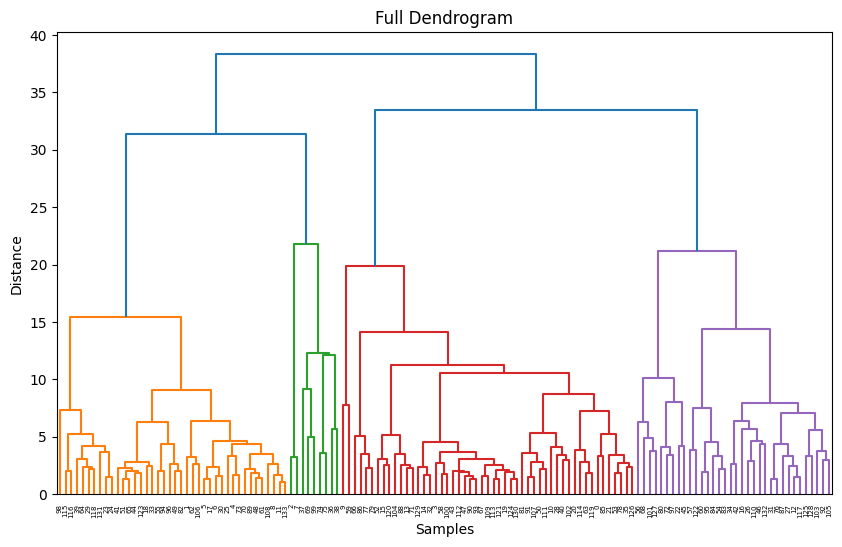

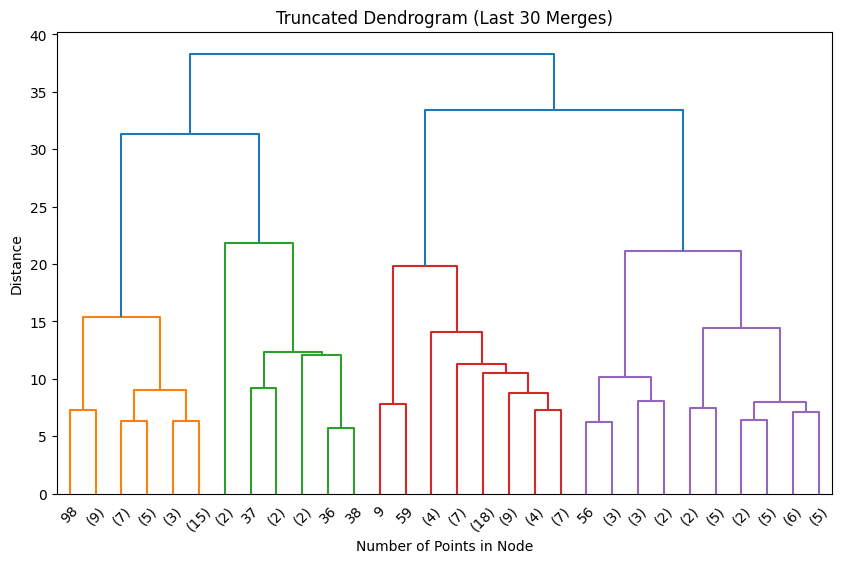

Silhouette Score: 0.24947045524695163


<ipython-input-32-d6afe6ad3e7a>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_clusters)


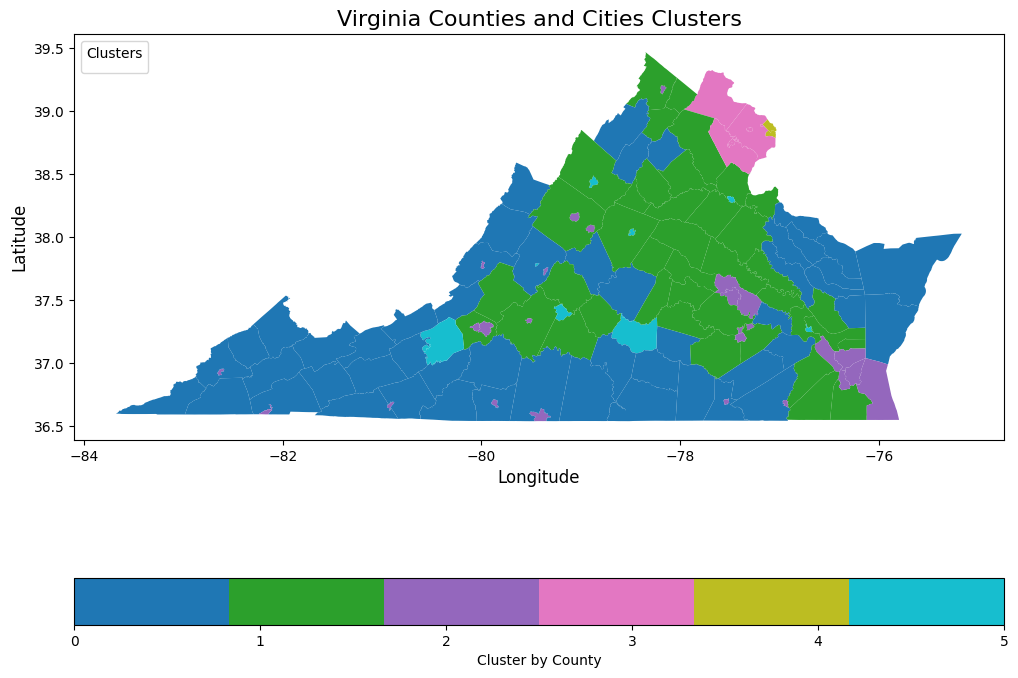

In [ ]:
reduced_data = va_counties_selected_prepared
linkage_matrix = linkage(reduced_data, method='ward')  # ward minimizes variance within clusters

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Full Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# truncated dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode="lastp", p=30, show_leaf_counts=True)
plt.title("Truncated Dendrogram (Last 30 Merges)")
plt.xlabel("Number of Points in Node")
plt.ylabel("Distance")
plt.show()

hac = AgglomerativeClustering(n_clusters=6, linkage='ward', metric='euclidean')
labels = hac.fit_predict(reduced_data)

sil_score = silhouette_score(reduced_data, labels)
print("Silhouette Score:", sil_score)


county_names = merged_va_counties[['County']]
hac_df = pd.DataFrame(va_counties_selected_prepared)
hac_df['cluster'] = labels
hac_df = hac_df.join(county_names)


plot_clusters_on_map(counties_df, hac_df,name_mapping, cluster_column='cluster' )

In [ ]:
find_cluster_min_unserved(hac_df)
print()
find_cluster_min_hotspot(hac_df)

Cluster with lowest total unserved_count_per_population: 1.0
Counties in cluster: ['Albemarle' 'Amelia' 'Amherst' 'Appomattox' 'Augusta' 'Botetourt'
 'Campbell' 'Caroline' 'Chesapeake' 'Chesterfield' 'Clarke' 'Culpeper'
 'Cumberland' 'Dinwiddie' 'Fauquier' 'Fluvanna' 'Frederick' 'Gloucester'
 'Goochland' 'Greene' 'Hanover' 'Isle of Wight' 'James City' 'King George'
 'King William' 'Louisa' 'Madison' 'New Kent' 'Orange' 'Poquoson'
 'Powhatan' 'Prince George' 'Roanoke County' 'Rockingham' 'Spotsylvania'
 'Stafford' 'Suffolk' 'Warren' 'York' 'Bedford County']

Cluster with lowest total hotspot_count_per_population: 1.0
Counties in cluster: ['Albemarle' 'Amelia' 'Amherst' 'Appomattox' 'Augusta' 'Botetourt'
 'Campbell' 'Caroline' 'Chesapeake' 'Chesterfield' 'Clarke' 'Culpeper'
 'Cumberland' 'Dinwiddie' 'Fauquier' 'Fluvanna' 'Frederick' 'Gloucester'
 'Goochland' 'Greene' 'Hanover' 'Isle of Wight' 'James City' 'King George'
 'King William' 'Louisa' 'Madison' 'New Kent' 'Orange' 'Poquoson'
 'P

### Clustering Method 3 - Gaussian Mixture


Gaussian Mixture Model Silhouette Score: 0.21294709908363502


<ipython-input-32-d6afe6ad3e7a>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_clusters)


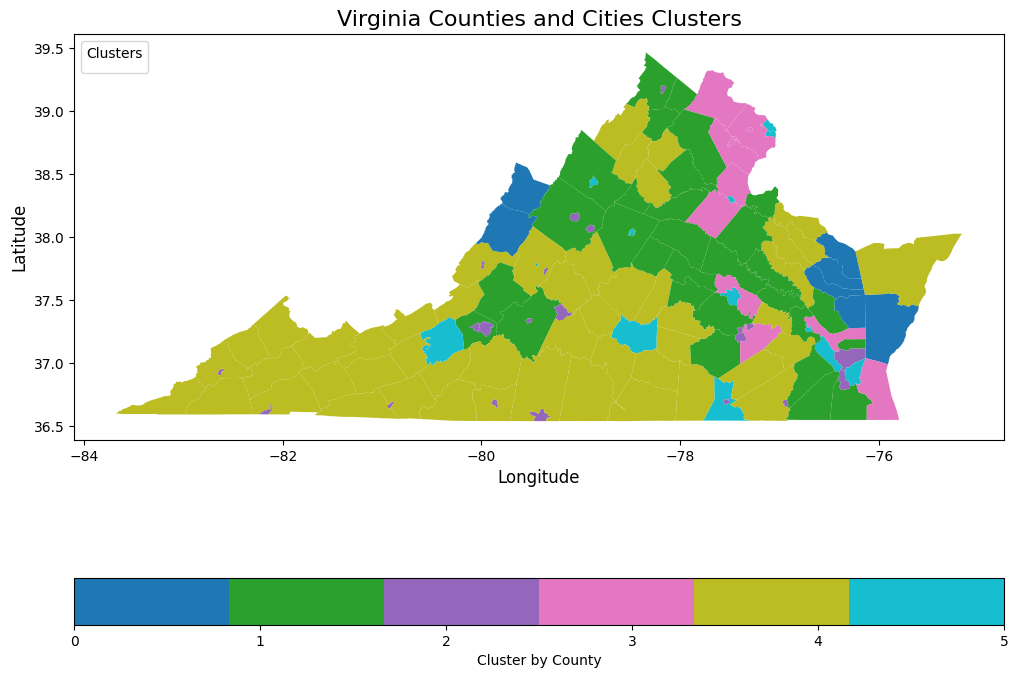

In [ ]:
gmm = GaussianMixture(n_components=6, random_state=42, covariance_type="spherical")
gmm_pred = gmm.fit_predict(va_counties_selected_prepared)

county_names = merged_va_counties[['County']]
gmm_df = pd.DataFrame(va_counties_selected_prepared)
gmm_df['cluster'] = gmm_pred
gmm_df = gmm_df.join(county_names)

gmm_sil_score = silhouette_score(va_counties_selected_prepared, gmm_pred)
print("Gaussian Mixture Model Silhouette Score:", gmm_sil_score)

plot_clusters_on_map(counties_df, gmm_df, name_mapping, cluster_column='cluster')

In [ ]:
find_cluster_min_unserved(gmm_df)
print()
find_cluster_min_hotspot(gmm_df)

Cluster with lowest total unserved_count_per_population: 1.0
Counties in cluster: ['Albemarle' 'Augusta' 'Botetourt' 'Caroline' 'Chesapeake' 'Chesterfield'
 'Clarke' 'Culpeper' 'Dinwiddie' 'Fauquier' 'Fluvanna' 'Frederick'
 'Gloucester' 'Goochland' 'Greene' 'Hanover' 'Isle of Wight' 'James City'
 'King George' 'King William' 'Louisa' 'New Kent' 'Orange' 'Poquoson'
 'Powhatan' 'Roanoke County' 'Rockingham' 'Suffolk' 'Warren'
 'Bedford County']

Cluster with lowest total hotspot_count_per_population: 1.0
Counties in cluster: ['Albemarle' 'Augusta' 'Botetourt' 'Caroline' 'Chesapeake' 'Chesterfield'
 'Clarke' 'Culpeper' 'Dinwiddie' 'Fauquier' 'Fluvanna' 'Frederick'
 'Gloucester' 'Goochland' 'Greene' 'Hanover' 'Isle of Wight' 'James City'
 'King George' 'King William' 'Louisa' 'New Kent' 'Orange' 'Poquoson'
 'Powhatan' 'Roanoke County' 'Rockingham' 'Suffolk' 'Warren'
 'Bedford County']


### Clustering Method 4 - DBSCAN

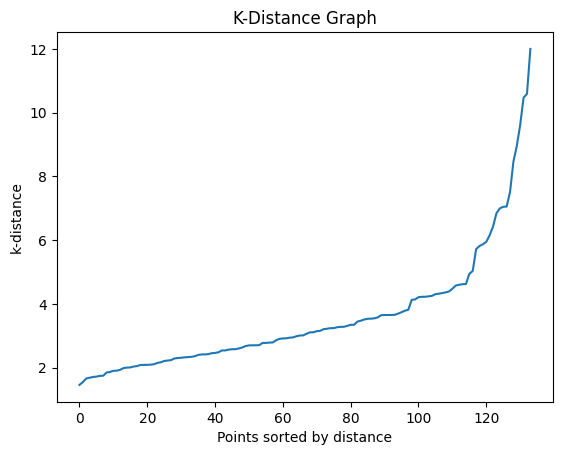

In [ ]:
k = 6
nn = NearestNeighbors(n_neighbors=k)
nn.fit(va_counties_selected_prepared)
distances, _ = nn.kneighbors(va_counties_selected_prepared)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("k-distance")
plt.title("K-Distance Graph")
plt.show()

Number of noise points: 8
DBSCAN Silhouette Score: 0.4872392743193918


<ipython-input-32-d6afe6ad3e7a>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_clusters)


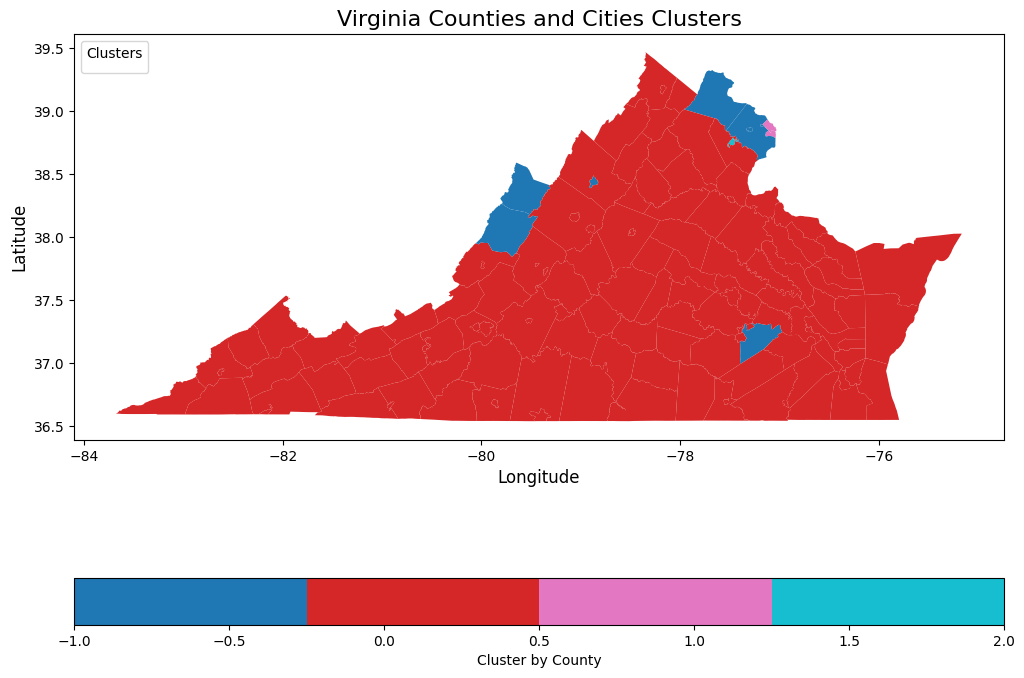

In [ ]:
dbscan = DBSCAN(eps = 4.5, min_samples=2)
dbscan_pred = dbscan.fit_predict(va_counties_selected_prepared)

dbscan_df = pd.DataFrame(va_counties_selected_prepared)
dbscan_df['cluster'] = dbscan_pred
dbscan_df = dbscan_df.join(county_names)

num_noise_points = (dbscan_pred == -1).sum()
print("Number of noise points:", num_noise_points)

dbscan_sil_score = silhouette_score(va_counties_selected_prepared[dbscan_pred != -1], dbscan_pred[dbscan_pred != -1])
print("DBSCAN Silhouette Score:", dbscan_sil_score)

plot_clusters_on_map(counties_df, dbscan_df, name_mapping, cluster_column='cluster')

In [ ]:
find_cluster_min_unserved(dbscan_df)
print()
find_cluster_min_hotspot(dbscan_df)

Cluster with lowest total unserved_count_per_population: 0.0
Counties in cluster: ['Accomack' 'Albemarle' 'Alleghany' 'Amelia' 'Amherst' 'Appomattox'
 'Augusta' 'Bland' 'Botetourt' 'Bristol' 'Brunswick' 'Buchanan'
 'Buckingham' 'Buena Vista' 'Campbell' 'Caroline' 'Carroll' 'Charles City'
 'Charlotte' 'Charlottesville' 'Chesapeake' 'Chesterfield' 'Clarke'
 'Colonial Heights' 'Covington' 'Craig' 'Culpeper' 'Cumberland' 'Danville'
 'Dickenson' 'Dinwiddie' 'Emporia' 'Essex' 'Fauquier' 'Floyd' 'Fluvanna'
 'Franklin City' 'Franklin County' 'Frederick' 'Fredericksburg' 'Galax'
 'Giles' 'Gloucester' 'Goochland' 'Grayson' 'Greene' 'Greensville'
 'Halifax' 'Hampton' 'Hanover' 'Henrico' 'Henry' 'Hopewell'
 'Isle of Wight' 'James City' 'King and Queen' 'King George'
 'King William' 'Lancaster' 'Lee' 'Lexington' 'Louisa' 'Lunenburg'
 'Lynchburg' 'Madison' 'Martinsville' 'Mathews' 'Mecklenburg' 'Middlesex'
 'Montgomery' 'Nelson' 'New Kent' 'Newport News' 'Norfolk' 'Northampton'
 'Northumberland' 'No

## Final Analysis

In [ ]:
def find_cluster_min_unserved_cluster_list(df):
    cluster_broadband_sum = df.groupby('cluster')['unserved_count_per_population'].sum().reset_index()
    min_broadband_cluster = cluster_broadband_sum.loc[cluster_broadband_sum['unserved_count_per_population'].idxmin()]
    min_cluster_number = min_broadband_cluster['cluster']
    counties_in_min_cluster = df[df['cluster'] == min_cluster_number]['County'].unique()
    return counties_in_min_cluster

def find_cluster_min_hotspot_cluster_list(df):
    cluster_broadband_sum = df.groupby('cluster')['hotspot_count_per_population'].sum().reset_index()
    min_broadband_cluster = cluster_broadband_sum.loc[cluster_broadband_sum['hotspot_count_per_population'].idxmin()]
    min_cluster_number = min_broadband_cluster['cluster']
    counties_in_min_cluster = df[df['cluster'] == min_cluster_number]['County'].unique()
    return counties_in_min_cluster

kmeans_broadband = find_cluster_min_unserved_cluster_list(test_df)
kmeans_hotspot = find_cluster_min_hotspot_cluster_list(test_df)

hac_broadband = find_cluster_min_unserved_cluster_list(hac_df)
hac_hotspot = find_cluster_min_hotspot_cluster_list(hac_df)

gmm_broadband = find_cluster_min_unserved_cluster_list(gmm_df)
gmm_hotspot = find_cluster_min_hotspot_cluster_list(gmm_df)

dbscan_broadband = find_cluster_min_unserved_cluster_list(dbscan_df)
dbscan_hotspot = find_cluster_min_hotspot_cluster_list(dbscan_df)

broadband_dict = {}
hotspot_dict = {}

mega_broadband_list = []
mega_broadband_list.extend(kmeans_broadband)
mega_broadband_list.extend(hac_broadband)
mega_broadband_list.extend(gmm_broadband)
mega_broadband_list.extend(dbscan_broadband)

mega_hotspot_list = []
mega_hotspot_list.extend(kmeans_hotspot)
mega_hotspot_list.extend(hac_hotspot)
mega_hotspot_list.extend(gmm_hotspot)
mega_hotspot_list.extend(dbscan_hotspot)

for c in mega_broadband_list:
    if c not in broadband_dict:
        broadband_dict[c] = 1
    else:
        broadband_dict[c] += 1

for c in mega_hotspot_list:
    if c not in hotspot_dict:
        hotspot_dict[c] = 1
    else:
        hotspot_dict[c] += 1

sorted_broadband = sorted(broadband_dict.items(), key=lambda x: x[1], reverse=True)

sorted_hotspot = sorted(hotspot_dict.items(), key=lambda x: x[1], reverse=True)

print("Sorted Broadband List by Count:")
for key, value in sorted_broadband:
    print(f"{key}: {value}")

print("\nSorted Hotspot List by Count:")
for key, value in sorted_hotspot:
    print(f"{key}: {value}")


Sorted Broadband List by Count:
Albemarle: 4
Caroline: 4
Chesapeake: 4
Chesterfield: 4
Culpeper: 4
Fauquier: 4
Fluvanna: 4
Frederick: 4
Gloucester: 4
Goochland: 4
Greene: 4
Hanover: 4
Isle of Wight: 4
James City: 4
King George: 4
King William: 4
New Kent: 4
Orange: 4
Poquoson: 4
Powhatan: 4
Suffolk: 4
Warren: 4
Spotsylvania: 3
Stafford: 3
York: 3
Augusta: 3
Botetourt: 3
Clarke: 3
Dinwiddie: 3
Louisa: 3
Roanoke County: 3
Rockingham: 3
Bedford County: 3
Henrico: 2
Prince George: 2
Virginia Beach: 2
Amelia: 2
Amherst: 2
Appomattox: 2
Campbell: 2
Cumberland: 2
Madison: 2
Accomack: 1
Alleghany: 1
Bland: 1
Bristol: 1
Brunswick: 1
Buchanan: 1
Buckingham: 1
Buena Vista: 1
Carroll: 1
Charles City: 1
Charlotte: 1
Charlottesville: 1
Colonial Heights: 1
Covington: 1
Craig: 1
Danville: 1
Dickenson: 1
Emporia: 1
Essex: 1
Floyd: 1
Franklin City: 1
Franklin County: 1
Fredericksburg: 1
Galax: 1
Giles: 1
Grayson: 1
Greensville: 1
Halifax: 1
Hampton: 1
Henry: 1
Hopewell: 1
King and Queen: 1
Lancaster: 1


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

prepared_columns = list(va_counties_selected.columns)
test_df[prepared_columns] = pd.DataFrame(va_counties_selected_prepared, columns=prepared_columns)

cluster_stats = test_df.groupby('cluster')[prepared_columns].agg(['mean', 'std'])

print("Cluster Centroids' Means and Standard Deviations:")
print(cluster_stats)

Cluster Centroids' Means and Standard Deviations:
        hotspot_count_per_population           unserved_count_per_population  \
                                mean       std                          mean   
cluster                                                                        
0                           0.475277  0.484659                      0.808229   
1                          -1.013961  0.560686                     -1.158847   
2                           1.251439  0.668267                      0.721931   
3                          -0.918796  0.755402                     -1.085931   
4                          -0.180869  0.494016                      0.012389   
5                           0.853270  1.224854                      1.037403   

                  AVE_FAM_SZ           FHH_CHILD_per_population            \
              std       mean       std                     mean       std   
cluster                                                                    

### Conclusions From K-Means Centroid Data

The analysis reveals distinct patterns among the clusters, highlighting disparities in internet infrastructure and demographic trends. Cluster 1 had significantly below-average hotspots per person, indicating a lack of accessible public Wi-Fi options, while Cluster 2 stood out with significantly above-average hotspots, suggesting better public internet infrastructure. In terms of broadband access, Clusters 1 and 3 had below-average counts of unserved broadband regions, pointing to relatively better access in these areas. In contrast, Cluster 5 showed an above-average number of unserved broadband regions but with a large standard deviation, indicating considerable variability; some counties in Cluster 5 were severely underserved, while others fared better.

The data also suggests that denser regions are more likely to have broadband access. Cluster 3, characterized by low crop acreage and low square mileage per person, exemplifies this trend, as these features typically correspond to urbanized areas. Income disparities are also evident. Clusters 1 and 3 had high median family incomes, likely contributing to better infrastructure and access to resources. In comparison, Clusters 2 and 5 had low median family incomes, reflecting potential affordability barriers and underinvestment. Additionally, Cluster 3 had a significantly above-average ratio of white residents per county population and a high ratio of households to individuals, demographic factors that may influence resource allocation and community investment.

These patterns underscore critical social implications. The disparity in hotspots and broadband access highlights a persistent digital divide, particularly in low-income and rural areas like those in Clusters 2 and 5, where communities may face barriers to education, employment, and healthcare opportunities. Stark differences between dense and sparsely populated regions suggest the need for targeted investments in rural counties. Cluster 3's demographic makeup raises questions about equity in infrastructure distribution, underscoring the importance of ensuring that minority and underserved communities in other clusters are not overlooked. Overall, these findings call for thoughtful, equitable policy-making and infrastructure investment to address systemic inequalities and foster connectivity for all communities.